In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import torch.nn as nn

In [2]:
class RoundSTE(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        output = torch.round(input)
        return output

    @staticmethod
    def backward(ctx, grad_output):
        return grad_output

def quant(x, alpha, bits):
    qmax = 2 ** bits - 1
    qmin = 0
    
    delta = 2 * alpha / qmax
    
    tq = (x + alpha) / delta
    tq = torch.clamp(tq, qmin, qmax)
    tq = RoundSTE.apply(tq)
    tq = tq * delta - alpha
    
    return tq

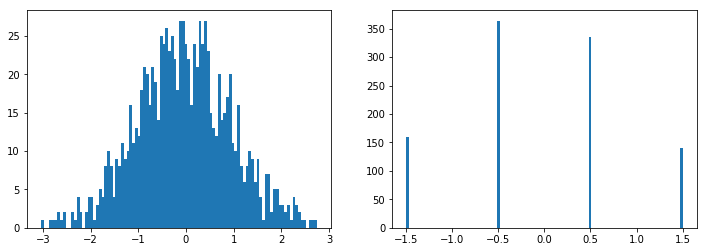

In [32]:
np.random.seed(0)
plt.rcParams['figure.figsize'] = [12, 4]
x = torch.tensor(np.random.normal(size=1000), dtype=torch.float).cuda()
plt.subplot(1, 2, 1)
plt.hist(x.cpu().flatten(), bins=100);
plt.subplot(1, 2, 2)
bits = 2
xq = quant(x, 1.5, bits)
plt.hist(xq.cpu().flatten(), bins=100);

Theoretical optimal clipping: 1.52


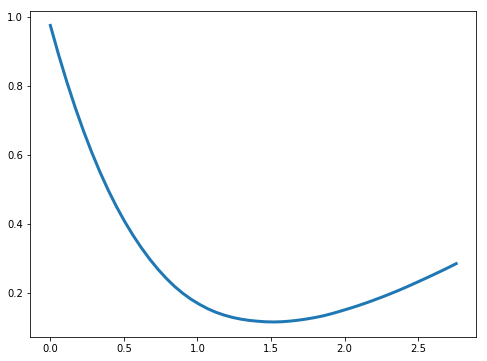

In [33]:
plt.rcParams['figure.figsize'] = [8, 6]
loss = torch.nn.MSELoss()
# loss = torch.nn.L1Loss()
clips = np.linspace(0., x.max().item(), 50)
losses = [loss(x, quant(x, c, bits=bits)).item() for c in clips]
plt.plot(clips, losses, linewidth=3);
opt_clip = clips[np.argmin(losses)]
print("Theoretical optimal clipping: {:.2f}".format(opt_clip))

In [150]:
c = torch.nn.Parameter(x.new_tensor([3]))
optimizer = torch.optim.SGD([c], lr=0.1)
criterion = nn.MSELoss()

In [153]:
c = torch.nn.Parameter(x.new_tensor([2]))
optimizer = torch.optim.SGD([c], lr=0.1)
criterion = nn.MSELoss()

xq = quant(x, c, bits=2)
loss = criterion(x, xq)
optimizer.zero_grad()
loss.backward()
optimizer.step()

c.grad

tensor([0.1143], device='cuda:0')

Theoretical optimal clipping: 1.92
SGD optimal clipping: 1.86


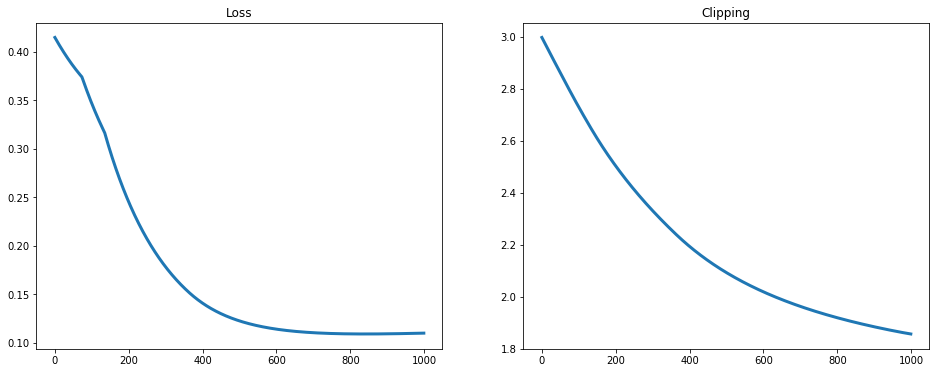

In [31]:
c = torch.nn.Parameter(x.new_tensor([3]))
optimizer = torch.optim.SGD([c], lr=0.01)
criterion = nn.MSELoss()

losses = []
c_opt = []

for i in range(1000):
    xq = quant(x, c, bits=bits)
    loss = criterion(x, xq)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    c_opt.append(c.item())
    
plt.rcParams['figure.figsize'] = [16, 6]

plt.subplot(1, 2, 1)
plt.plot(losses, linewidth=3)
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(c_opt, linewidth=3);
plt.title('Clipping');

print("Theoretical optimal clipping: {:.2f}".format(opt_clip))
print("SGD optimal clipping: {:.2f}".format(c_opt[-1]))